In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import configs
from finetune import finetune
import utils
import models
import plot_utils

In [3]:
task_config = configs.TaskConfig()
task_config.lora_adapt_type = configs.LoraAdaptType.attention_mlp
task_config.lora_init_scale = 1e-3
task_config.num_train_steps = 2000
task_config.train_batch_size = 16
task_config.max_seq_length = 128
task_config.log_eval_steps = 100
task_config.learning_rate = 1e-4
task_config.decay_ratio = 0.1
task_config.save_step_points = [
    0,
    1,
    10,
    20,
    30,
    100,
    500,
    1000,
    1500,
    task_config.num_train_steps,
]
task_config.identifier = "intro"

# finetune(task_config)

In [4]:
experiment_path = utils.get_experiment_path(task_config, seed=0)

In [5]:
experiment_path

'/Users/cjyaras/Desktop/deep-lora-transformers/glue/experiments/stsb_lora_type=attention-mlp_depth=3_lr=0.0001_steps=2000_seed=0_intro'

In [5]:
sv_vals_dict = plot_utils.get_final_spectra(experiment_path)

2024-03-21 21:26:06.721872: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Some weights of the model checkpoint at bert-base-cased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'LayerNorm', 'scale'), ('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'kernel')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

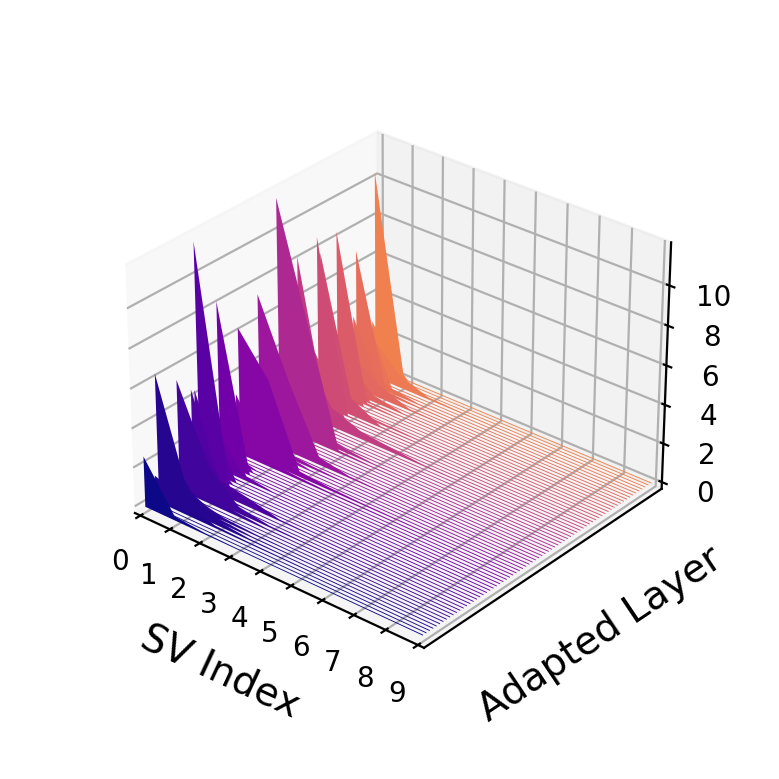

In [10]:
series = np.array(list(sv_vals_dict.values()))[:, :10]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_utils.plot_series(ax, series, color="plasma", zoom=0.8, alpha=1.0, linewidth=0)
ax.set_yticks([])
ax.set_xlabel("\nSV Index", fontsize=14)
ax.set_ylabel("Adapted Layer", fontsize=14)
ax.set_yticks([])
# ax.set_zticks([])  # type: ignore
fig.savefig(os.path.join("figures", "final_spectra.png"), dpi=500, bbox_inches="tight")

In [10]:
cosine_angle_vals_dict, step_vals = plot_utils.get_cosine_angle_traj(experiment_path, 8, side="right")

Some weights of the model checkpoint at bert-base-cased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'scale')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased 

Loading step 0
Loading step 1
Loading step 10
Loading step 20
Loading step 30
Loading step 100
Loading step 500
Loading step 1000
Loading step 1500
Loading step 2000


In [11]:
step_vals = task_config.save_step_points

In [72]:
series[series[:, 4] > 0.5].shape

(40, 10)

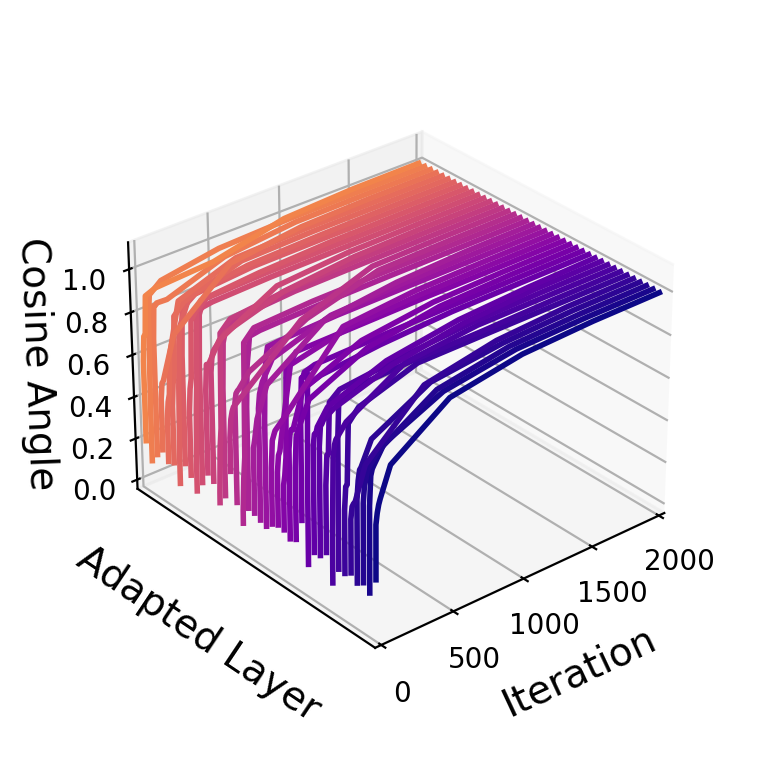

In [76]:
series = np.array(list(cosine_angle_vals_dict.values()))
filtered_series = series[series[:, 4] > 0.5]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_utils.plot_series(
    ax,
    filtered_series,
    color="plasma",
    y_points=step_vals,
    zoom=0.8,
    elev=30,
    azim=-130,
    roll=0,
    linewidth=2.0,
    alpha=1.0
)
ax.set_xticks(np.linspace(0, task_config.num_train_steps, 5, dtype=int))
ax.set_xlabel("\nIteration", fontsize=14)
ax.set_ylabel("Adapted Layer", fontsize=14)
ax.set_yticks([])
ax.set_zlabel("Cosine Angle", fontsize=14)  # type: ignore
fig.savefig(os.path.join("figures", "cosine_angle_traj.png"), dpi=500, bbox_inches="tight")

In [77]:
with open(os.path.join(experiment_path, "results.json")) as f:
    results = json.load(f)
step_vals, loss_vals = list(zip(*[(pair['step'], pair['value']) for pair in results['train_loss']]))

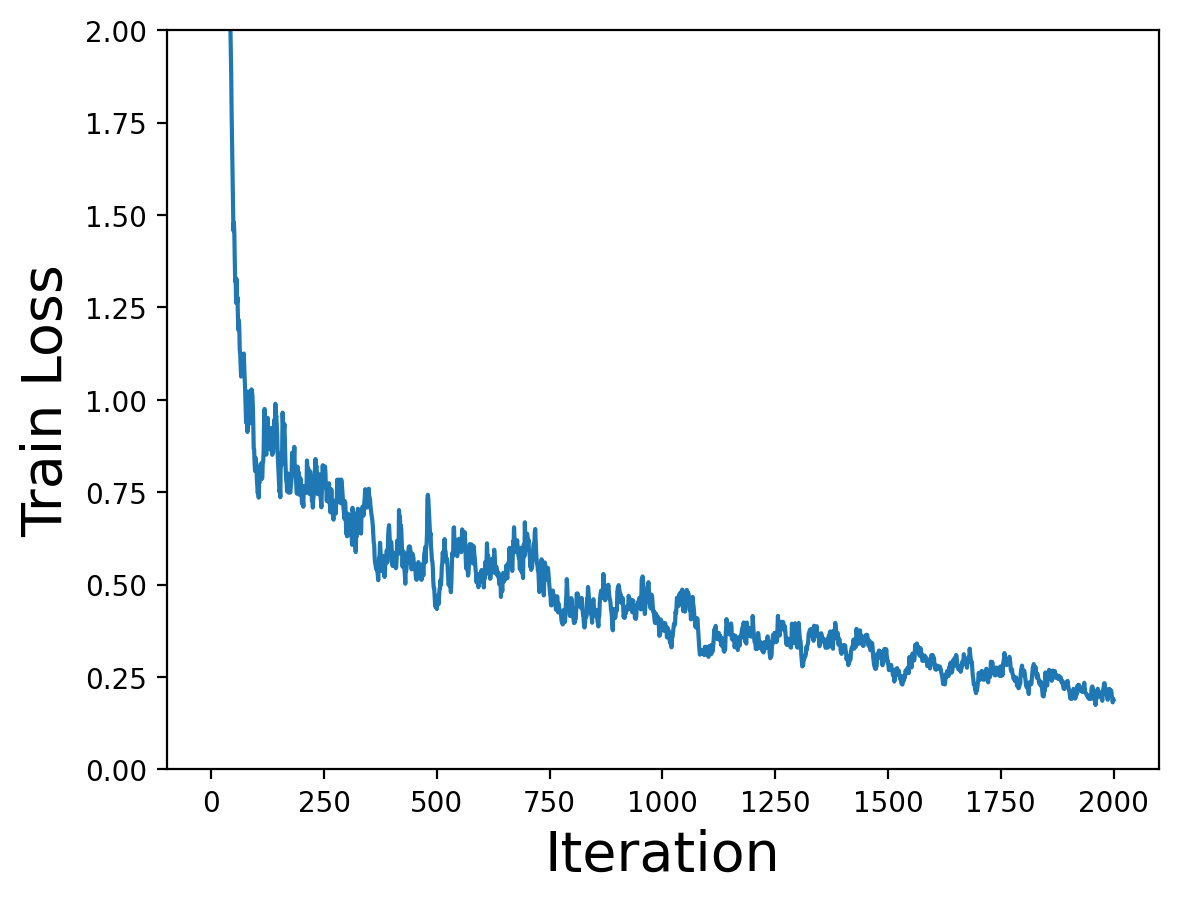

In [87]:
plt.plot(step_vals, plot_utils.smooth(loss_vals, 0.9))
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Train Loss', fontsize=20)
plt.ylim([0, 2])
plt.savefig(os.path.join("figures", "train_loss.png"), dpi=500, bbox_inches='tight')